# Model_AE_Regular_CNN

## Notes
- Regular CNN Autoencoder
- Created 2 versions within this notebook, but no difference in terms of the model architecture
- The only difference is that v.2 uses HorizontalFlip and RandomRotation

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

# import image based recommendation module
from ibfilter import ImageBasedRecommendation

---
## Data Prep
---

In [10]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [11]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [12]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [13]:
# # Define transformations and initialize Dataset
# transform_steps = transforms.Compose([transforms.ToTensor(),
#                                       transforms.CenterCrop(200),
#                                       transforms.Normalize(mean=[0], std=[1.0])
#                                      ])
# manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [14]:
# # Set DataLoader

# # Split train and data
# train_size = int(manga_dataset.__len__() * 0.75)
# val_size = int(manga_dataset.__len__() - train_size)
# train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # All dataloader
# all_data_loader = DataLoader(manga_dataset, batch_size=32)

In [15]:
# # Check Dataset
# img_ex = train_dataset.__getitem__(0)
# print(len(img_ex))
# print(type(img_ex))
# print(img_ex[0].shape)

# # Check DataLoader
# input_tensor, output_tensor, character_id = next(iter(train_loader))
# print(f"input batch shape: {input_tensor.size()}")
# print(f"output batch shape: {output_tensor.size()}")
# img_ex = input_tensor[0].squeeze()
# plt.imshow(img_ex, cmap="gray")
# plt.show()

In [16]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * 0.75)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    all_data_loader = DataLoader(manga_dataset, batch_size=32)
    return train_loader, val_loader, all_data_loader

---
## Autoencoder
---

In [17]:
# Encoder
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        # note on nn.ReLU(inplace=True) -> https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948/4
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.sig5 = nn.Sigmoid()
        self.maxpool5 = nn.MaxPool2d(2)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = self.maxpool3(self.relu3(self.conv3(x)))
        x = self.maxpool4(self.relu4(self.conv4(x)))
        x = self.maxpool5(self.sig5(self.conv5(x)))
        
        return x

In [18]:
# Decoder
# keeping the same shape as input -> https://stackoverflow.com/questions/68794161/how-to-solve-dimensions-mismatch-error-in-tensorflow-autoencoder
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        # shaping output: H_out = ((H_in - 1) * str) - (2 * pad) + (dilation * kernel-1) + output_pad + 1
        # just make output (h, w) to be 200,200

        self.deconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2) # (6-1)*2-(2*0)+(1*(2-1)+0+1 = 10-0+1+1 = 12
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, 2, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, 2, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1)
        self.sig5 = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.deconv1(x)) # shape = [32, 128, 12, 12] height is 12, so correct.
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x = self.relu4(self.deconv4(x))
        x = self.sig5(self.deconv5(x))

        return x

In [20]:
# # test encoder
# encoder = Encoder()
# encoder.train()
# input_tensor, output_tensor, character_id = next(iter(train_loader))
# print("character_id: ", character_id)
# print(input_tensor.shape)
# encoder_output = encoder(input_tensor)
# print("encoder output shape: ", encoder_output.shape) # [batch_size, channel, h, w]

# # test decoder
# decoder = Decoder()
# decoder.train()
# decoder_output = decoder(encoder_output)
# print("decoder output shape: ", decoder_output.shape) # [batch_size, channel, h, w]

# # show the decoder output -> just shows patterns since it's the very first layer
# img_ex = decoder_output[0].detach().numpy().squeeze()
# plt.imshow(img_ex, cmap="gray")
# plt.show()

---
## Test runs
---

In [21]:
# # initialize again, set to train mode, send models to gpu
# encoder = Encoder()
# decoder = Decoder()
# encoder.train()
# decoder.train()
# device = "cuda"
# encoder.to(device)
# decoder.to(device)

# # set loss function, optimizer
# criterion = nn.MSELoss()
# ae_params = list(encoder.parameters()) + list(decoder.parameters())
# optimizer = optim.Adam(ae_params, lr=0.005)

# # train
# losses = []

# for epoch in tqdm(range(10)):
#     running_loss = 0.0
#     for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
#         train_img = train_img.to(device)
#         target_img = target_img.to(device)

#         optimizer.zero_grad()
#         # forward
#         enc_output = encoder(train_img)
#         dec_output = decoder(enc_output)

#         loss = criterion(dec_output, target_img)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     avg_loss = running_loss / counter
#     losses.append(avg_loss)

In [22]:
# # quick plot of training losses
# plt.plot(losses)

In [23]:
# encoder.eval()
# decoder.eval()

# # validate
# val_losses = []

# for epoch in tqdm(range(10)):
#     with torch.no_grad():
#         running_loss = 0.0
#         for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
#             train_img = train_img.to(device)
#             target_img = target_img.to(device)

#             # forward
#             enc_output = encoder(train_img)
#             dec_output = decoder(enc_output)

#             # calculate loss
#             loss = criterion(dec_output, target_img)
#             running_loss += loss.item()
#         avg_loss = running_loss / counter
#         val_losses.append(avg_loss)

In [24]:
# # quick plot of training losses
# plt.plot(val_losses)

---
## Train
---

In [ ]:
# version setting
version = "v2"

In [25]:
# Putting training and validation into methods
def train_step(encoder, decoder, train_loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = criterion(dec_output, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    return avg_loss


def val_step(encoder, decoder, val_loader, criterion, device):
    encoder.eval()
    decoder.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            # calculate loss
            loss = criterion(dec_output, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        return avg_loss

In [ ]:
#     - transforms.ToTensor()
#     - transforms.CenterCrop(200)
#     - transforms.Normalize(mean=[0], std=[1.0])
#     - 500 images
#     - train_ratio=0.8, batch_size=8
#     - optim.Adam(ae_params, lr=0.005)
#     - 100 epochs

In [41]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)

# prep model
encoder = Encoder()
decoder = Decoder()
device = "cuda"
encoder.to(device)
decoder.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(ae_params, lr=0.005)

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(encoder, decoder, train_loader, criterion, optimizer, device=device)
    train_losses.append(train_loss)
    # print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(encoder, decoder, val_loader, criterion, device=device)
    val_losses.append(val_loss)
    # print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_encoder = copy.deepcopy(encoder)
        best_decoder = copy.deepcopy(decoder)
        torch.save(best_encoder.state_dict(), "../assets/character_images/models_and_embeddings/encoder_model_"+version+".pt")
        torch.save(best_decoder.state_dict(), "../assets/character_images/models_and_embeddings/decoder_model_"+version+".pt")
        min_loss = val_loss
        

100%|████████████████████████████████████████████████████████| 100/100 [04:50<00:00,  2.90s/it]


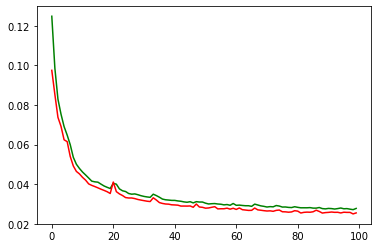

In [42]:
# plot training & validation losses
plt.plot(train_losses,"g", val_losses, "r")
plt.show()

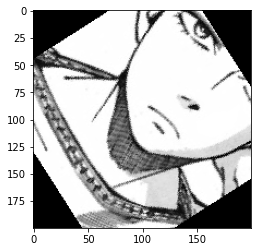

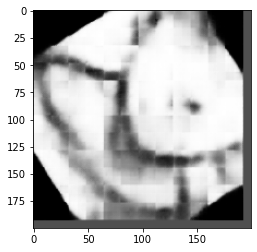

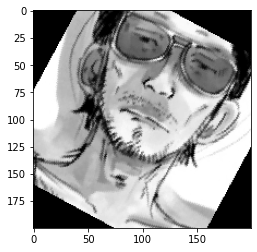

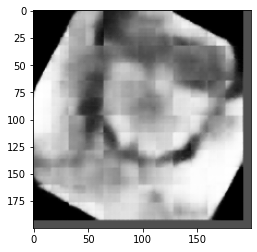

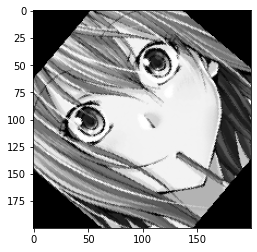

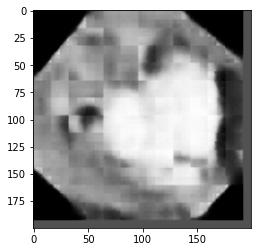

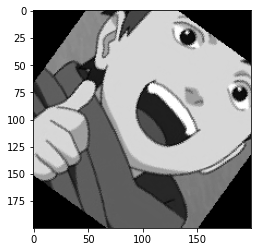

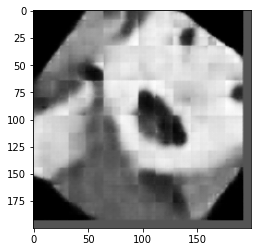

In [43]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

encoder.eval()
decoder.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, d_img in zip(train_img[0], dec_output[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(d_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

## Interpretation of v.1 (Normal Autoencoder with CNN)
- Character image search results seem convincing, but it doesn't really see the "drawing style" of the images.
- It pulls out images that are similarly colored (=similar contrast).
- It also pulls out images with similar face angles.
- Title-based query doesn't really return the expected results (Because it's not really learning the "style" yet)

## Interpretation of v.2 (Normal Autoencoder with CNN but RandomRotation and HFlip)
- Training & validation curve looks better. Less sign of overfitting compared to v.1
- Flips and rotations seems better

---
## Create embedding
---

In [44]:
version = "v2"

In [45]:
# create embedding

encoder.eval()
embedding = torch.zeros((1, 256, 6, 6))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in all_data_loader:
        train_img = train_img.to(device)
        enc_output = encoder(train_img).cpu()
        embedding = torch.cat((embedding, enc_output), 0)
        character_ids.append(character_id)

In [46]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :, :, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 256, 6, 6])
shape of flattened embedding:  (500, 9216)


---
## Similarity calculations (Character-based, Title-based)
---

In [2]:
# initialize
ibr_search = ImageBasedRecommendation("/mnt/disks/sdb/home/dy0904k/assets/character_images/character_images_grayscale/", "v2")

model version:  v2


Queried character:  ['Jirou Azuma']  who appears in:  ['BLACK TORCH']


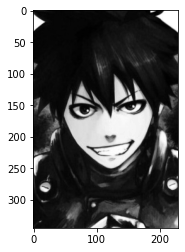

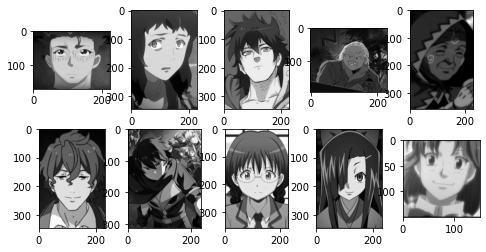

Similar characters (in the order of appearance)
Character:  ['Kamioka']  who appears in :  ['Shijou Saikyou no Deshi Kenichi']
Character:  ['Saika  Gasai']  who appears in :  ['Mirai Nikki']
Character:  ['Han Ye']  who appears in :  ['Yao Shen Ji']
Character:  ['Nezu']  who appears in :  ['AKIRA']
Character:  ['Yaobikuni']  who appears in :  ['Mugen no Juunin']
Character:  ['Philip Boreas Greyrat']  who appears in :  ['Mushoku Tensei: Isekai Ittara Honki Dasu']
Character:  ['Han-Soo Kang']  who appears in :  ['FFF Geum Gwansimyongsa']
Character:  ['Manami Okuda']  who appears in :  ['Ansatsu Kyoushitsu']
Character:  ['Tsubaki Kasugano']  who appears in :  ['Mirai Nikki' 'Mirai Nikki: Paradox' 'Mirai Nikki: Mosaic']
Character:  ['Nanako Itagaki']  who appears in :  ['Hajime no Ippo']
[ 69883  30664  85564  86707  30007  30658  30584 113666  30988]


In [3]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=137304, top_n=10)
print(res)

Querying title:  ['Berserk']


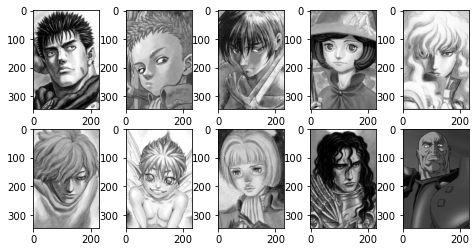

Similar title:  ['Mahoutsukai no Yome']


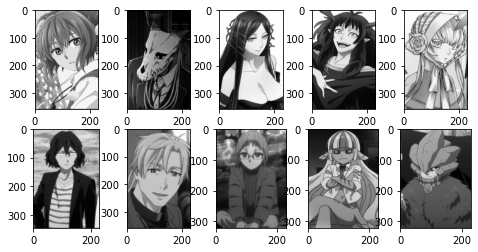

Similar title:  ['Gokushufudou']


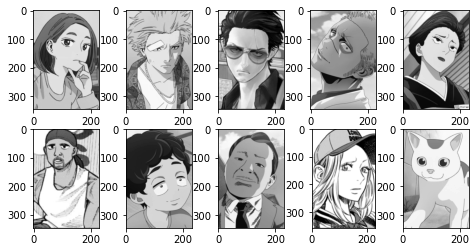

Similar title:  ['Onani Master Kurosawa']


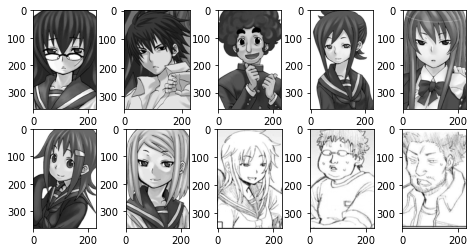

[85435, 101233, 38967]


In [4]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30002, top_n=3)
print(res)